<a href="https://colab.research.google.com/github/Frellaa/Frellaa.github.io/blob/main/full_blast_db_metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 41.4 MB/s eta 0:00:00


In [ ]:
from Bio import AlignIO, Entrez
import pandas as pd

# Load the MSA result from FASTA file
alignment_file = '/content/clustalo-I20241116-205551-0161-74887740-p1m.aln-fasta'  # Replace with your file path
alignment = AlignIO.read(alignment_file, "fasta")

# Set up Entrez for fetching species names
Entrez.email = "fiamregina@gmail.com"  # Replace with your email address

# Function to calculate alignment metrics
def calculate_metrics(alignment):
    alignment_length = alignment.get_alignment_length()
    results = []

    # Filter sequences into contigs and references
    contigs = [seq for seq in alignment if seq.id.startswith('k')]
    references = [seq for seq in alignment if not seq.id.startswith('k')]

    # Iterate through contigs and references
    for contig in contigs:
        for reference in references:
            match_count = 0
            total_length = 0

            # Calculate matches and alignment length
            for pos in range(alignment_length):
                if contig.seq[pos] != "-" and reference.seq[pos] != "-":
                    total_length += 1
                    if contig.seq[pos] == reference.seq[pos]:
                        match_count += 1

            # Calculate metrics
            if total_length > 0:
                Si = match_count / total_length  # Illeszkedési arány
                Wi = len(contig.seq.replace("-", "")) / len(reference.seq.replace("-", ""))  # Súlyozási tényező
                I = (1 - Si) if Wi < 1 else 0  # Inkonzisztencia index
                M = Wi * Si - I  # Final metric

                # Append results
                results.append({
                    "Contig": contig.id,
                    "Reference": reference.id,
                    "Si": Si,
                    "Wi": Wi,
                    "I": I,
                    "M": M
                })

    return pd.DataFrame(results)

# Generate metrics dataframe
metrics_df = calculate_metrics(alignment)

# Function to analyze top X scores per contig and determine likely species
def analyze_top_scores(metrics_df, top_x=5):
    grouped = metrics_df.groupby('Contig')
    likely_species = []

    for contig, group in grouped:
        # Sort by metric M in descending order and select top X entries
        top_references = group.sort_values(by='M', ascending=False).head(top_x)

        # Calculate weighted score for each reference
        reference_scores = top_references.groupby('Reference')['M'].sum().reset_index()
        reference_scores = reference_scores.sort_values(by='M', ascending=False)

        # Append results with metrics for each likely species in descending order of likelihood
        for _, row in reference_scores.iterrows():
            best_match = top_references[top_references['Reference'] == row['Reference']].iloc[0]
            likely_species.append({
                "Contig": contig,
                "Likely_Species": row['Reference'],
                "Si": best_match['Si'],
                "Wi": best_match['Wi'],
                "I": best_match['I'],
                "M": best_match['M'],
                "Probability_Score": row['M']
            })

    return pd.DataFrame(likely_species)

# Analyze top scores to determine likely species with metrics included
likely_species_df = analyze_top_scores(metrics_df)

# Function to fetch species name from NCBI using reference ID
def fetch_species_name(reference_id):
    handle = Entrez.efetch(db="nucleotide", id=reference_id, rettype="gb", retmode="text")
    record = handle.read()
    handle.close()
    organism_name = 'Unknown'
    for line in record.splitlines():
        if line.startswith("  ORGANISM"):
            organism_name = line.replace("  ORGANISM  ", "").strip()
            break
    return organism_name

# Add species names to the likely_species_df
def add_species_names(df):
    df['Species_Name'] = df['Likely_Species'].apply(fetch_species_name)
    return df

# Add species names to the dataframe
likely_species_df = add_species_names(likely_species_df)

# Sort by probability score in descending order
likely_species_df = likely_species_df.sort_values(by='Probability_Score', ascending=False)

# Display or save the likely species results with metrics and species names
print(likely_species_df)
likely_species_df.to_csv('likely_species_results_with_metrics.csv', index=False)


        Contig Likely_Species        Si         Wi         I          M  \
0   k141_15220     JF795591.1  0.512915  54.959707  0.000000  28.189665   
1   k141_15220     MK742814.1  0.383886  71.109005  0.000000  27.297770   
2   k141_15220     GU937853.1  0.747277  32.688453  0.000000  24.427319   
3   k141_15220     GU937854.1  0.747277  32.688453  0.000000  24.427319   
4   k141_15220     GU937857.1  0.747826  32.617391  0.000000  24.392136   
..         ...            ...       ...        ...       ...        ...   
19  k141_21573     MW423692.1  0.419118   0.411765  0.580882  -0.408304   
26  k141_28301     AY456187.1  0.432000   0.025957  0.568000  -0.556787   
27  k141_28301    NC_005935.1  0.432000   0.025957  0.568000  -0.556787   
29  k141_28301     PP190482.1  0.337607   0.026026  0.662393  -0.653607   
28  k141_28301    NC_088557.1  0.337607   0.026026  0.662393  -0.653607   

    Probability_Score        Species_Name  
0           28.189665   Argulus siamensis  
1          

In [13]:
from Bio import Entrez
import pandas as pd

# Entrez beállítása
Entrez.email = "fiamregina@gmail.com"  # Cseréld le a saját e-mail címedre

# Funkció a fajnév lekéréséhez NCBI-ból
def fetch_species_name(reference_id):
    try:
        handle = Entrez.efetch(db="nucleotide", id=reference_id, rettype="gb", retmode="text")
        record = handle.read()
        handle.close()
        organism_name = 'Unknown'
        for line in record.splitlines():
            if line.startswith("  ORGANISM"):
                organism_name = line.replace("  ORGANISM  ", "").strip()
                break
        return organism_name
    except Exception as e:
        return "Error"

# Töltse be az összesített eredményeket
file_path = 'all_comparisons_results.csv'  # Az elmentett összehasonlítások fájlja
results_df = pd.read_csv(file_path)

# Adjunk hozzá egy új oszlopot a faj nevével
results_df['Species'] = results_df['Reference'].apply(fetch_species_name)

# Mentse el az új táblázatot fajokkal kiegészítve
results_with_species_file = 'all_comparisons_results_with_species.csv'
results_df.to_csv(results_with_species_file, index=False)

print(f"Eredmények fajokkal kiegészítve elmentve: '{results_with_species_file}'")


Eredmények fajokkal kiegészítve elmentve: 'all_comparisons_results_with_species.csv'


In [ ]:
metrics_df.to_csv('all_comparisons_results.csv', index=False)
print("Minden összehasonlítás eredménye mentve: 'all_comparisons_results.csv'")


Minden összehasonlítás eredménye mentve: 'all_comparisons_results.csv'


* Minden kis k-val kezdődő kontigra elvégzi az összes összehasonlítást azokkal a szekvenciákkal, amelyek nem kis k-val kezdődnek.
* Minden kontig esetében kiszámítja az összes lehetséges összehasonlítás eredményét (pl. Si, Wi, I, M metrikákat).
* Minden kontigra meghatározza az 5 legjobban illeszkedő referencia szekvenciát a számított M értékek alapján.
* Csak a top 5 eredményt írja ki a fájlba (likely_species_results_with_metrics.csv), amely tartalmazza:
  - A kontig azonosítóját.
  - A referencia azonosítóját.
  - Az Si, Wi, I, és M értékeket.
  - A valószínűségi pontszámot (Probability_Score), amely a referencia összesített súlyozott pontja.


In [11]:
# Analízis

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the table
file_path = '/content/all_comparisons_results_with_species.csv'
results_df = pd.read_csv(file_path)

# Aggregate metrics by species
species_agg = results_df.groupby('Species').agg({
    'M': ['sum', 'mean', 'count']
}).reset_index()
species_agg.columns = ['Species', 'Total_M', 'Mean_M', 'Count']

print(species_agg)

# Identify the most likely species
most_likely_species = species_agg.sort_values('Total_M', ascending=False).iloc[0]
print("Most Likely Species:")
print(most_likely_species)


                     Species      Total_M    Mean_M  Count
0         Argulus americanus     2.783224  0.071365     39
1        Argulus bengalensis     4.477486  0.895497      5
2            Argulus bicolor    20.373809  2.910544      7
3          Argulus catostomi   173.329499  2.088307     83
4           Argulus coregoni   148.133903  2.178440     68
5         Argulus flavescens    63.273012  2.530920     25
6          Argulus foliaceus   248.805967  1.463565    170
7            Argulus indicus    40.844002  1.317548     31
8          Argulus japonicus  1210.439763  1.795905    674
9      Argulus longicaudatus    36.944211  1.420931     26
10       Argulus mongolianus    42.010373  1.909562     22
11            Argulus monodi     3.021884  3.021884      1
12           Argulus nobilis     1.041993  1.041993      1
13       Argulus pugettensis     1.111476  1.111476      1
14    Argulus rhipidiophorus     1.063707  0.066482     16
15         Argulus siamensis   238.298328  1.632180    1

In [20]:
results_df

,Contig,Reference,Si,Wi,I,M,Species
0,k141_17075,PP621942.1,0.867733,2.497931,0.000000,2.167536,Argulus sp. BOLD:AFA9490
1,k141_17075,PP621940.1,0.860465,2.497931,0.000000,2.149383,Argulus sp. BOLD:ACM2751
2,k141_17075,PP621938.1,0.855072,2.491059,0.000000,2.130036,Argulus sp. BOLD:ACM2751
3,k141_17075,PP621941.1,0.863570,2.494490,0.000000,2.154168,Argulus sp. BOLD:ACM2751
4,k141_17075,PP621935.1,0.863570,2.494490,0.000000,2.154168,Argulus sp. BOLD:ACM2751
...,...,...,...,...,...,...,...
1585,k141_21573,OL841703.1,0.241611,0.656637,0.758389,-0.599739,Argulus coregoni
1586,k141_21573,OL841704.1,0.248322,0.677007,0.751678,-0.583562,Argulus coregoni
1587,k141_21573,OL841706.1,0.248322,0.743487,0.751678,-0.567054,Argulus coregoni
1588,k141_21573,OL841705.1,0.248322,0.690875,0.751678,-0.580118,Argulus coregoni


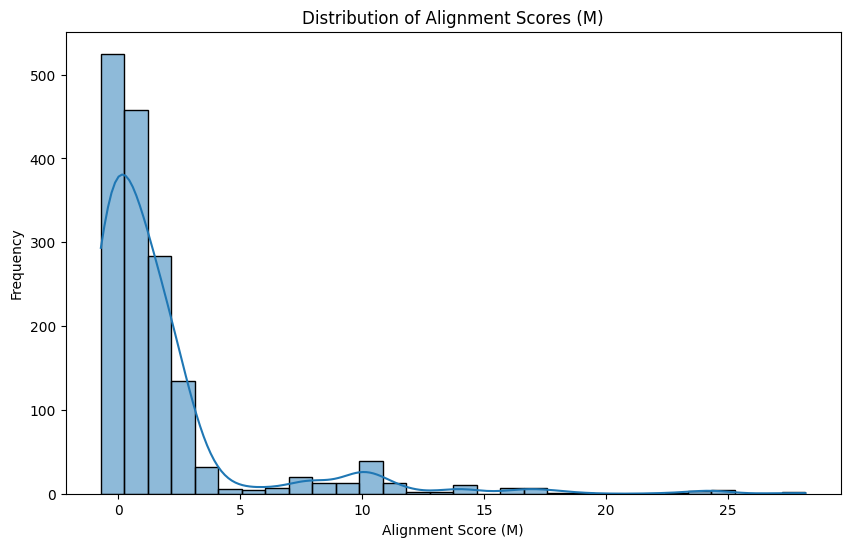

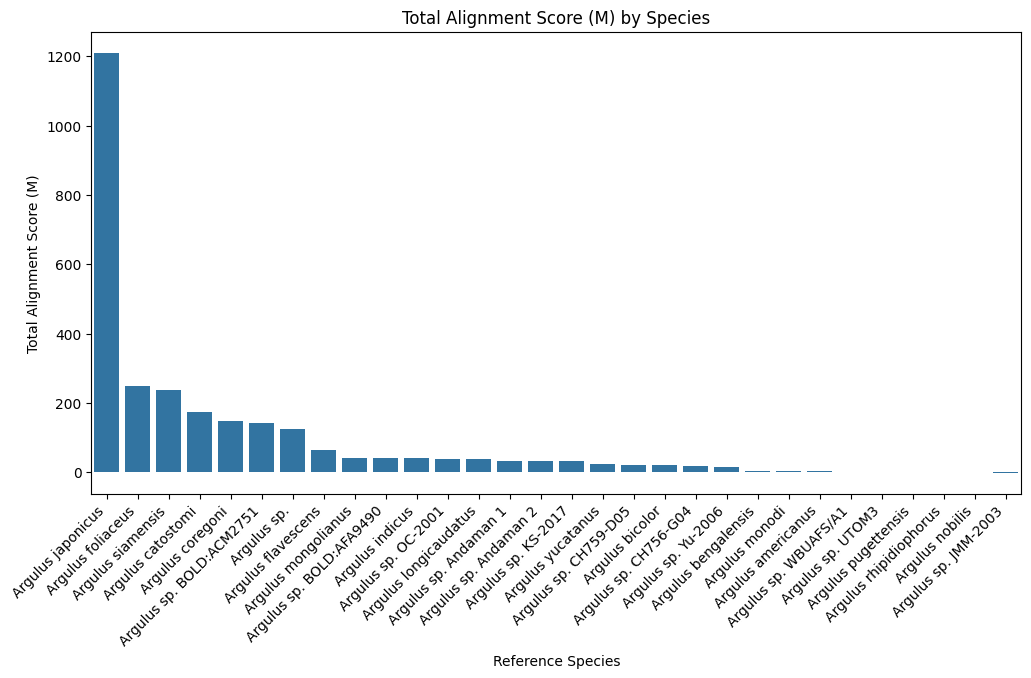

In [21]:
# Histogram of M values
plt.figure(figsize=(10, 6))
sns.histplot(results_df['M'], bins=30, kde=True)
plt.title('Distribution of Alignment Scores (M)')
plt.xlabel('Alignment Score (M)')
plt.ylabel('Frequency')
plt.show()

# Bar plot of species aggregated metrics
plt.figure(figsize=(12, 6))
sns.barplot(data=species_agg.sort_values('Total_M', ascending=False), x='Species', y='Total_M')
plt.title('Total Alignment Score (M) by Species')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total Alignment Score (M)')
plt.xlabel('Reference Species')
plt.show()


